In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyiron_base import Project
from pyiron_workflow import Workflow, job

In [2]:
@Workflow.wrap_as.function_node()
def ReadInput(filename, area):
    """
    My custom function to read an input file and process it
    """
    df = pd.read_csv(filename, delimiter=";", header=[0,1], decimal=',')
    df['Stress'] = df['Load']*1000/area
    load = df['Load']*1000
    strain = df['Extensometer elongation'].values.flatten()
    stress = df['Stress'].values.flatten()
    return stress, strain

In [3]:
@Workflow.wrap_as.function_node()
def CalculateYoungsModulus(stress, strain, strain_cutoff=0.2):
    arg = np.argsort(np.abs(np.array(strain)-strain_cutoff))[0]
    fit = np.polyfit(strain[:arg], stress[:arg], 1)
    youngs_modulus = fit[0]*(1/0.01)/1000
    return youngs_modulus

In [4]:
@Workflow.wrap_as.function_node()
def Plot(stress, strain):
    plt.plot(strain, stress)
    plt.xlabel("Strain [%]");
    plt.ylabel("Stress [MPa]");
    return 1

In [5]:
wf = Workflow("youngs_modulus")
wf.read_input = ReadInput()

#add keyword args
#black formatter

wf.youngs_modulus = CalculateYoungsModulus(
    wf.read_input.outputs.stress,
    wf.read_input.outputs.strain,
)

wf.plot = Plot(
    wf.read_input.outputs.stress,
    wf.read_input.outputs.strain
)

{'youngs_modulus__youngs_modulus': 188.4145327564869, 'plot__1': 1}

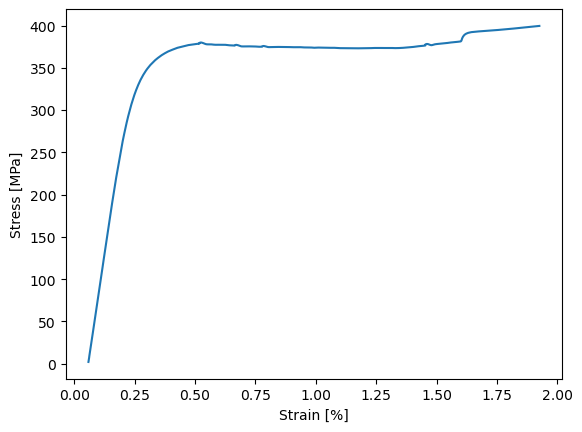

In [6]:
wf(read_input__filename='dataset_1.csv', read_input__area=120.636)

In [7]:
wf.draw();
# wf.draw(size=(15,20))

In [8]:
@Workflow.wrap_as.macro_node("youngs_modulus")
def YoungsModulus(wf, filename, area, strain_cutoff):
    """
    The graph constructor a Macro expects must take the macro as its only argument
    (i.e. "self" from the macro's perspective) and return nothing.
    Inside, it should add nodes to the macro, wire their connections, etc.
    """
    wf.read_input = ReadInput(filename, area)
    wf.youngs_modulus = CalculateYoungsModulus(
        wf.read_input.outputs.stress,
        wf.read_input.outputs.strain,
        strain_cutoff
    )
    return wf.youngs_modulus.outputs.youngs_modulus
    
macro = YoungsModulus()

In [9]:
macro(filename='dataset_1.csv', area=120.636, strain_cutoff=0.2, storage_backend="tinybase")

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/node.py:767: UserWarning: The keyword 'storage_backend' was not found among input labels. If you are trying to update a node keyword, please use attribute assignment directly instead of calling
  warnings.warn(


{'youngs_modulus': 188.4145327564869}

In [10]:
pr = Project('fgg')

In [11]:
nj = pr.create.job.NodeOutputJob("youngs_modulus")
nj.input["node"] = macro

In [12]:
nj.input

DataContainer({'node': <__main__.YoungsModulus object at 0x13324dfd0>})

In [13]:
nj.run()

The job _node_outd4ed14cbb789e4fbd870769e5df44fb1 was saved and received the ID: 9568


In [14]:
nj.output.youngs_modulus

188.4145327564869

In [15]:
for x in np.linspace(0.05, 0.6, 12):
    job = pr.create.job.NodeOutputJob(f'job_{x}')
    job.input["node"] = YoungsModulus(
        filename='dataset_1.csv', 
        area=120.636, 
        strain_cutoff=x, 
    )
    job.run()

The job _node_out5278b6c918101ff8a9ddd082aefb67bb was saved and received the ID: 9569


/var/folders/ff/j3764z6n37386m647kqygyzw0000gp/T/ipykernel_57958/1252028215.py:4: RankWarning: Polyfit may be poorly conditioned
  fit = np.polyfit(strain[:arg], stress[:arg], 1)


The job _node_out4938188ab7436a2aa076f40d6e840718 was saved and received the ID: 9570
The job _node_out61087cc4f3c39cbb8671588f4ef1b5e6 was saved and received the ID: 9571
The job _node_out023fa4aa9e6dc62406141ae8533f8ce0 was saved and received the ID: 9572
The job _node_out94ffbbab8d3bf7b675d06060929acfac was saved and received the ID: 9573
The job _node_out78f82aa6b43e58358b61d946790bf9df was saved and received the ID: 9574
The job _node_out300a0585fa5bb0952a893f1ce9d2495f was saved and received the ID: 9575
The job _node_out6b28e10e19e02566de55f2cbf1b819a4 was saved and received the ID: 9576
The job _node_outeb90f26222b3dc1c34d0eac241f92ff8 was saved and received the ID: 9577
The job _node_out337982dddbae11c83f764d26912c36c5 was saved and received the ID: 9578
The job _node_outae1b483b8cbde9b5e36a47e4167a69e9 was saved and received the ID: 9579
The job _node_out2c7c8b4db92af23dadf00f07f28b0e61 was saved and received the ID: 9580


In [17]:
# pr.remove_jobs(silently=True, recursive=True)